# Recognize people with mask and not

## Importing libraries

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import History
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2

%matplotlib inline

In [2]:
BASE_DIR = '../input/face-mask-detection'
image_dir = os.path.join(BASE_DIR, 'images')
annot_dir = os.path.join(BASE_DIR, 'annotations')

label2category = {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}
category2label = {v: k for k, v in label2category.items()}
datas = []

for root, dirs, files in os.walk(annot_dir):
    for file in files:
        tree = ET.parse(os.path.join(root, file))
        data = {'path': None, 'objects': []}
        data['path'] = os.path.join(image_dir, tree.find('filename').text)
        for obj in tree.findall('object'):
            label = label2category[obj.find('name').text]
            # top left co-ordinates
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            # bottom right co-ordinates
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)
            data['objects'].append([label, xmin, ymin, xmax, ymax])
        datas.append(data)

print('Total images :', len(datas))

Total images : 853


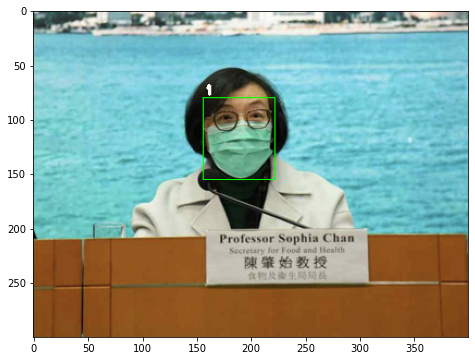

In [3]:
index = np.random.randint(0, len(datas))
img = cv2.imread(datas[index]['path'])
for (category, xmin, ymin, xmax, ymax) in datas[index]['objects']:
    # Draw bounding boxes
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
    cv2.putText(img, str(category), (xmin+2, ymin-3), cv2.FONT_HERSHEY_SIMPLEX, 0.38, (255,255,255), 2)
# Show image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
img_size = (150, 150)
X = []
Y = []

for data in datas:
    img = cv2.imread(data['path'])
    for (category, xmin, ymin, xmax, ymax) in data['objects']:
        roi = img[ymin : ymax, xmin : xmax]
        roi = cv2.resize(roi, (150, 150))
        data = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        target = to_categorical(category, num_classes=len(category2label))
        X.append(data)
        Y.append(target)
        
X = np.array(X)
Y = np.array(Y)


## Splitting and Reshaping

In [5]:
from sklearn.model_selection import train_test_split
#splitting
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1)

#reshaping
X_train = X_train.reshape(X_train.shape[0], 150, 150, 3)
X_test = X_test.reshape(X_test.shape[0], 150, 150, 3)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 3664
number of test examples = 408
X_train shape: (3664, 150, 150, 3)
Y_train shape: (3664, 3)
X_test shape: (408, 150, 150, 3)
Y_test shape: (408, 3)


## Building a VGG19

In [6]:
base= tf.keras.applications.VGG19(include_top=False, input_shape=img_size+(3,))
base.trainable = False

model = Sequential([base, Flatten(),Dense(100, activation='relu'),  Dense(3,activation='softmax')])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
history = model.fit(X_train,Y_train,epochs=8, validation_split=0.1)

model.save('VGG19-MaskDetection.h5')

Epoch 1/8
104/104 [==============================] - 418s 4s/step - loss: 2.1055 - accuracy: 0.8488 - val_loss: 0.3027 - val_accuracy: 0.8937
Epoch 2/8
104/104 [==============================] - 423s 4s/step - loss: 0.1172 - accuracy: 0.9542 - val_loss: 0.2944 - val_accuracy: 0.9155
Epoch 3/8
104/104 [==============================] - 432s 4s/step - loss: 0.0377 - accuracy: 0.9887 - val_loss: 0.3465 - val_accuracy: 0.9346
Epoch 4/8
104/104 [==============================] - 414s 4s/step - loss: 0.0197 - accuracy: 0.9952 - val_loss: 0.3906 - val_accuracy: 0.9319
Epoch 5/8
104/104 [==============================] - 415s 4s/step - loss: 0.0067 - accuracy: 0.9992 - val_loss: 0.3731 - val_accuracy: 0.9292
Epoch 6/8
104/104 [==============================] - 412s 4s/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.4873 - val_accuracy: 0.9292
Epoch 7/8
104/104 [==============================] - 412s 4s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.4412 - val_accuracy: 0.9319
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


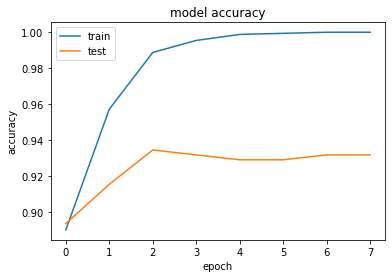

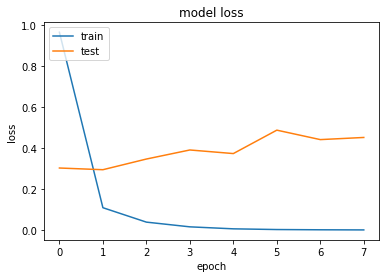

In [8]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
model.evaluate(X_test, Y_test)

13/13 [==============================] - 47s 4s/step - loss: 0.3422 - accuracy: 0.9534


[0.3421839773654938, 0.9534313678741455]

Number 0 = No mask
Number 1 = Mask
Number 2 = Mask weared incorrectly
The number is = 1


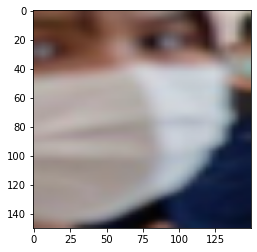

In [19]:
image_index = np.random.randint(0, len(X_test))


plt.imshow(X_test[image_index].reshape(150, 150,3),cmap='Greys')
pred = model.predict(X_test[image_index].reshape(1, 150, 150, 3))

print('Number 0 = No mask')
print('Number 1 = Have Mask')
print('Number 2 = Mask weared incorrectly')
print('The number is = ' + str(pred.argmax()))